In [47]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_absolute_error
from sklearn.decomposition import TruncatedSVD
from tabulate import tabulate
import matplotlib.pyplot as plt

In [48]:
# Set random seed for reproducibility
random_seed = 42
np.random.seed(random_seed)

In [49]:
# Load the dataset
menu_data = pd.read_csv('updated_dataset.csv')

In [50]:
# Preprocessing: Handle missing values
menu_data['description'] = menu_data['description'].fillna('')

In [51]:
# Combine textual features into one column for TF-IDF
menu_data['combined_text'] = menu_data['category_x'] + ' ' + menu_data['name_x'] + ' ' + menu_data['description']

In [52]:
# Initialize TF-IDF Vectorizer with bi-grams
tfidf = TfidfVectorizer(stop_words='english', ngram_range=(1, 3))
tfidf_matrix = tfidf.fit_transform(menu_data['combined_text'])

In [53]:
# Adding weight to the description feature
menu_data['description_weighted'] = menu_data['description'] * 3
menu_data['combined_text'] = menu_data['category_x'] + ' ' + menu_data['name_x'] + ' ' + menu_data['description_weighted']

In [54]:
# Keep a copy of the original ratings
menu_data['original_rating'] = menu_data['Rating']
menu_data['original_price'] = menu_data['price']

In [55]:
# Normalize numerical features (rating and price)
scaler = StandardScaler()
menu_data[['Rating', 'price']] = scaler.fit_transform(menu_data[['Rating', 'price']])

In [56]:
#Combine TF-IDF matrix with normalized numerical features
numerical_features = menu_data[['Rating', 'price']]
extended_numerical_features = csr_matrix(numerical_features.values)

In [57]:
# Combine sparse matrices directly
combined_features = hstack([tfidf_matrix, extended_numerical_features])

In [58]:
# Apply TruncatedSVD for dimensionality reduction
svd = TruncatedSVD(n_components=150, random_state=random_seed)
reduced_features = svd.fit_transform(combined_features)

In [59]:
def cosine_similarity_manual(matrix):
    dot_product = np.dot(matrix, matrix.T)
    norm = np.linalg.norm(matrix, axis=1)
    similarity = dot_product / (norm[:, None] * norm[None, :])
    return similarity

# Calculate the cosine similarity matrix
cosine_sim = cosine_similarity_manual(reduced_features)

In [60]:
def recommend_menu(menu_name, menu_data, cosine_sim, top_n=5):
    if menu_name not in menu_data['name_x'].values:
        raise ValueError(f"{menu_name} not found in menu.")

    # Get the index of the input menu item
    input_idx = menu_data[menu_data['name_x'] == menu_name].index[0]
    
    # Get similarity scores for the input item
    sim_scores = list(enumerate(cosine_sim[input_idx]))
    
    # Sort by similarity score
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Get the top n most similar items (including the input menu item itself)
    top_items = sim_scores[:top_n]
    
    recommended_menus = [{
        'Menu Item': menu_data.loc[i, 'name_x'],
        'Category': menu_data.loc[i, 'category_x'],
        'Rating': menu_data.loc[i, 'original_rating'],
        'Description': menu_data.loc[i, 'description'],
        'Price': menu_data.loc[i, 'original_price'],
        'Booth Number': menu_data.loc[i, 'restaurant_id'],
        'Booth Name': menu_data.loc[i, 'name_y'],
        'Similarity Score': score
    } for i, score in top_items]

    return recommended_menus

In [61]:
# Function to predict rating for a menu item
def predict_rating(menu_name, menu_data, cosine_sim, top_n=5):
    if menu_name not in menu_data['name_x'].values:
        raise ValueError(f"{menu_name} not found in menu.")

    input_idx = menu_data[menu_data['name_x'] == menu_name].index[0]
    sim_scores = list(enumerate(cosine_sim[input_idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    top_items = sim_scores[1:top_n+1]

    total_rating = 0
    total_similarity = 0

    for i, score in top_items:
        total_rating += menu_data.loc[i, 'original_rating'] * score
        total_similarity += score

    if total_similarity > 0:
        return total_rating / total_similarity
    else:
        return menu_data['original_rating'].mean()  # fallback to the mean rating if no similar items


In [62]:
# Function to evaluate Precision and Recall
def evaluate_precision_recall(menu_names, ground_truth, menu_data, cosine_sim, top_n=5):
    precision_scores = []
    recall_scores = []

    for menu_name in menu_names:
        # Get recommended items
        recommended_items = recommend_menu(menu_name, menu_data, cosine_sim, top_n)

        # Get ground truth items
        relevant_items = ground_truth.get(menu_name, [])

        # Calculate Precision and Recall
        recommended_set = set(item['Menu Item'] for item in recommended_items)
        relevant_set = set(relevant_items)

        intersection = recommended_set.intersection(relevant_set)

        precision = len(intersection) / len(recommended_set) if recommended_set else 0
        recall = len(intersection) / len(relevant_set) if relevant_set else 0

        precision_scores.append(precision)
        recall_scores.append(recall)

    mean_precision = np.mean(precision_scores)
    mean_recall = np.mean(recall_scores)

    return mean_precision, mean_recall

In [63]:

# Function to evaluate Mean Absolute Error (MAE)
def evaluate_mae(menu_names, menu_data, cosine_sim, top_n=5):
    mae_scores = []

    for menu_name in menu_names:
        # Get recommended items with actual ratings and similarities
        recommended_items = recommend_menu(menu_name, menu_data, cosine_sim, top_n)

        # Calculate MAE for top recommended items
        actual_ratings = []
        predicted_ratings = []

        for item in recommended_items:
            item_name = item['Menu Item']
            actual_rating = item['Rating']
            predicted_rating = predict_rating(item_name, menu_data, cosine_sim, top_n)

            actual_ratings.append(actual_rating)
            predicted_ratings.append(predicted_rating)

        if actual_ratings and predicted_ratings:
            mae = mean_absolute_error(actual_ratings, predicted_ratings)
            mae_scores.append(mae)

    mean_mae = np.mean(mae_scores)

    return mean_mae

In [64]:
# Example usage:
menu_names = ['Banana Smoothie', 'Beef Lettuce Wrap', 'Adult Mac N Cheese','Mushroom and Pepper Jack Toastie', 'Scallop with Broccoli']
ground_truth = {
    'Banana Smoothie': ['Banana Smoothie', 'Coconut Milk Drink', 'Coconut Sticky Rice', 'Livingston', 'Young Coconut Drink'],
    'Beef Lettuce Wrap': ['Beef Lettuce Wrap', 'Lort', 'Gulab-e-Jamun', 'Bo La Lot', 'Philly Beef and Cheese Sub'],
    'Adult Mac N Cheese': ['Adult Mac N Cheese', 'Homestyle Alfredo', 'Quattro Formaggi Pasta', 'The Distillery Burger', 'Uplands Cheese Puff Salad'],
    'Mushroom and Pepper Jack Toastie': ['Mushroom and Pepper Jack Toastie', 'The Bleu Bayou Burger', 'Hotwurst', 'Brown Bag Special', 'Wood-Grilled Sweet Onion Quesadilla'],
    'Scallop with Broccoli': ['Scallop with Broccoli', 'Oyster Sauce With Broccoli and Mushroom', 'Broccoli with Bean Curd', 'Chicken with Broccoli and Snow Peas', 'Yu-shan Vegetable']
}

In [65]:
# Evaluate Precision and Recall
precision, recall = evaluate_precision_recall(menu_names, ground_truth, menu_data, cosine_sim)
print(f"Mean Precision: {precision:.4f}, Mean Recall: {recall:.4f}")

Mean Precision: 0.8800, Mean Recall: 0.8800


In [66]:
# Evaluate MAE
mae = evaluate_mae(menu_names, menu_data, cosine_sim)
print(f"Mean MAE: {mae:.4f}")

Mean MAE: 0.2878


In [67]:
# Plotting the results
plt.figure(figsize=(10, 6))

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

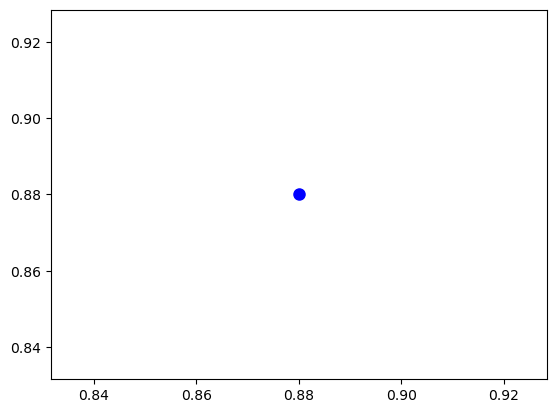

In [68]:
# Plot Precision and Recall
plt.plot([precision], [recall], marker='o', markersize=8, color='blue', label='Precision-Recall')

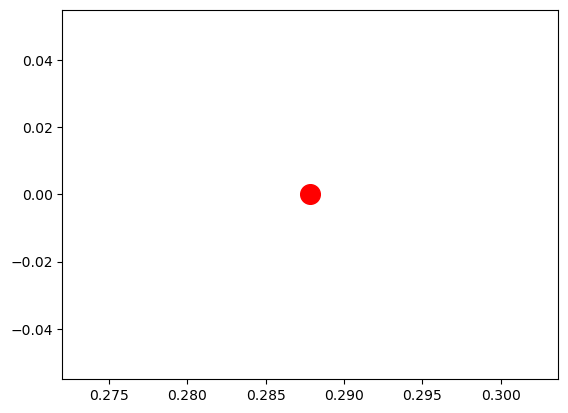

In [69]:
# Plot MAE
plt.scatter([mae], [0], marker='o', s=200, color='red', label='Mean Absolute Error')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


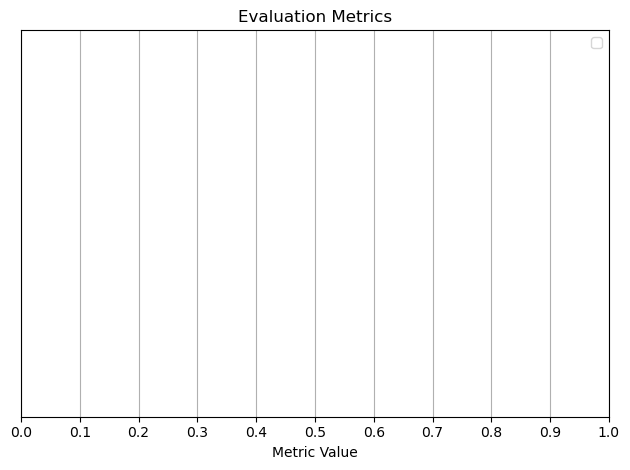

In [70]:
plt.title('Evaluation Metrics')
plt.xlabel('Metric Value')
plt.xlim(0, 1)
plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks([])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()